In [15]:
import pandas as pd
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report

from sklearn.metrics import roc_curve, roc_auc_score

import numpy as np

In [16]:
PATH = "/Users/jamesliounis/Documents/Projects/World Bank/NLP Project/data-use/data/annotated/training_data_annotated_datastilbert_v1.xlsx"

data = pd.read_excel(PATH)

data.head()

,Unnamed: 0,text,label,data_origin,DatastilBERT_v1_classification
0,0.0,We analyze the relationship between climate ch...,1,GPT-generated data (old),"('WITH_DATA', 0.958536684513092)"
1,1.0,Using a dataset from the World Trade Organizat...,1,GPT-generated data (old),"('WITH_DATA', 0.9534607529640198)"
2,2.0,This study examines the impact of school-based...,1,GPT-generated data (old),"('WITH_DATA', 0.9466453790664673)"
3,3.0,We explore the impact of electricity access on...,1,GPT-generated data (old),"('WITH_DATA', 0.9585261940956116)"
4,4.0,To investigate the relationship between social...,1,GPT-generated data (old),"('WITH_DATA', 0.9394758343696594)"


# Performance metrics

We start by naively calculating the performance metrics to make sure that the model has picked up signal. 

In [17]:
make_tuple = lambda s: ast.literal_eval(s)

data['DatastilBERT_v1_classification'] = data['DatastilBERT_v1_classification'].apply(make_tuple)

data['DataBERT_label'] = data['DatastilBERT_v1_classification'].apply(lambda x: x[0])
data['DataBERT_label'] = data['DataBERT_label'].apply(lambda x: 1 if 'WITH_DATA' in x else 0)
data['confidence'] = data['DatastilBERT_v1_classification'].apply(lambda x: round(x[1], 4))

data['Delta'] = data["label"] - data['confidence']

data.drop('DatastilBERT_v1_classification', inplace=True, axis=1)
data.drop('Unnamed: 0', inplace=True, axis=1)

{'precision': 0.9974919383733429, 'recall': 0.9998802825332216, 'f1_score': 0.9986846825301926, 'accuracy': 0.9986831078654376}


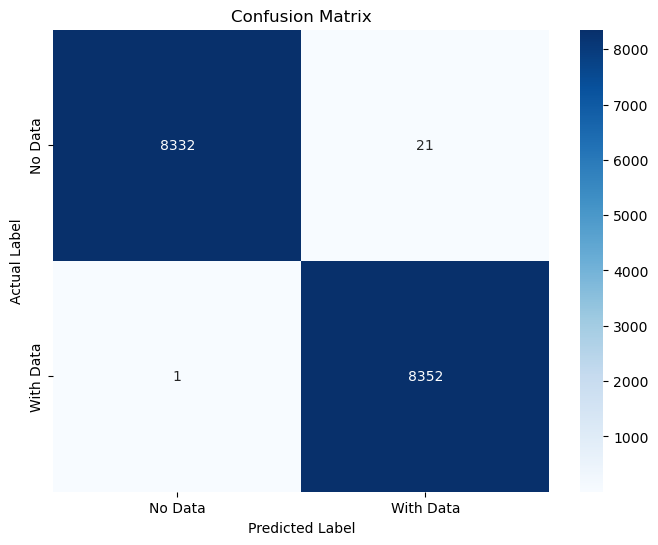

In [18]:
# Calculating performance metrics
y_true = data['label']
y_pred = data['DataBERT_label']

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred)

metrics_dic= {
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "accuracy": accuracy
}

print(metrics_dic)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Data", "With Data"], yticklabels=["No Data", "With Data"])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

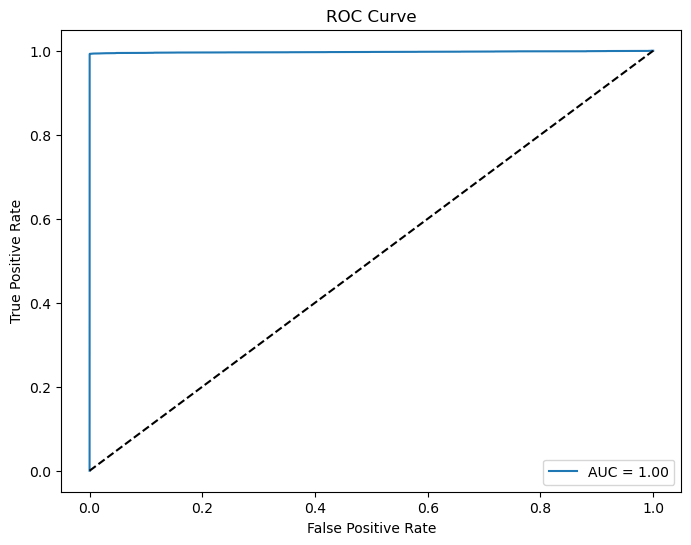

0.9970542595017481

In [19]:
# Assuming the 'confidence' values are the probability estimates for the positive class
y_score = data['confidence']

# Calculating the ROC curve and AUC metric
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_score = roc_auc_score(y_true, y_score)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

auc_score


The AUC is approximately 0.997, indicating an excellent ability to distinguish between the two classes. An AUC close to 1.0 suggests that the model has a high rate of true positive classifications while maintaining a low rate of false positives.

## Analyze FN

In [20]:
fn = data.query('DataBERT_label == 0 & label == 1')

fn['text'].to_list()[0]

'We use Webscope advertising logs, which consist of a large collection of user-page interactions from a major search and advertising company, to investigate privacy-protected algorithms for targeted advertising in online search.'

The model designates only ONE false negative, which is the following:

```bash
'We use Webscope advertising logs, which consist of a large collection of user-page interactions from a major search and advertising company, to investigate privacy-protected algorithms for targeted advertising in online search.'
```

We can attribute this to the following plausible causes:

1. **Specific Dataset Reference**: The mention of "Webscope advertising logs" directly refers to a specific dataset. The model's failure to recognize this phrase as a dataset could stem from its insufficient exposure to diverse naming conventions or lack of familiarity with this particular dataset.

2. **Contextual Understanding**: The model might have missed the context that "Webscope advertising logs" is not just a phrase but a dataset name. Ensuring the model understands different ways datasets can be introduced or mentioned in a sentence is crucial.

3. **Complex Sentence Structure**: The sentence has a complex structure, elaborating on the dataset's content and its application ("a large collection of user-page interactions... for targeted advertising in online search"). The model might have struggled to identify the dataset mention due to the embedded clauses and additional details that follow the actual dataset name.

4. **Lack of Keywords**: Often, dataset mentions are accompanied by keywords like "dataset," "data," "study," etc. In this sentence, while "logs" can be indicative, it might not be as strong a signal as more conventional dataset indicators. Training the model to recognize a wider array of context clues indicating data references can help mitigate this issue.

5. **Domain-Specific References**: "Webscope advertising logs" is possibly a domain-specific dataset that might not be common across broader datasets. If the training data did not adequately cover the domain specificity or the terminology was not well-represented, the model might not recognize it as a dataset.

**#TODO**: Diversify data sources as much as possible in training data. Include logs, databases, datasets, images, etc.

## Analyze FP

In [21]:
fp = data.query('DataBERT_label == 1 & label == 0')

fp['text'].to_list()

['The Organisation of the Petroleum Exporting Countries (OPEC) is a group of oil-producing nations that coordinate their oil policies.',
 'The Intergovernmental Panel on Climate Change (IPCC) has concluded that climate change is real and primarily caused by human activities.',
 'The Universal Declaration of Human Rights was created by the World Health Organization.',
 'The Paris Climate Agreement was designed to increase global greenhouse gas emissions.',
 'Behavioral research is based solely on the interpretation of qualitative data.',
 'The North American Free Trade Agreement (NAFTA) is an agreement between the United States, Canada, and Mexico aimed at promoting trade and economic growth.',
 'The Universal Declaration of Human Rights (UDHR) was adopted by the United Nations General Assembly in 1948.',
 'The International Atomic Energy Agency is responsible for monitoring compliance with the Nuclear Non-Proliferation Treaty.',
 'The Kyoto Protocol was an international agreement to re

By identifying the False Positives, we notice the following errors:

1. **Erroneous Format Recognition**: The model demonstrates a tendency to misclassify sentences with formal structures or acronyms as dataset mentions, likely due to its training on a specific format where dataset citations often include an acronym following the dataset name. To mitigate this issue, the model should be fine-tuned to discern between generic acronyms and those explicitly denoting datasets. Improving the model's exposure to a variety of textual formats could enhance its precision in distinguishing relevant contexts.

Examples:

```bash
'The Organisation of the Petroleum Exporting Countries (OPEC) is a group of oil-producing nations that coordinate their oil policies.'
'The International Atomic Energy Agency (IAEA) is an international organization that focuses on regulating weapons of mass destruction.'
```

2. **Misinterpretation of Organization Names/Entities**: The model appears to conflate the mention of organizational names or entities with the utilization of datasets, possibly due to patterns in the training data where dataset usage is frequently associated with specific organizations. The model must be refined to differentiate between mere mentions of organizations and explicit references to data emanating from them. Clarifying this distinction is crucial, especially in contexts where organizations are referenced in relation to data but are not the direct source of a dataset.

Examples:
```bash
'The World Health Organization is a specialized agency of the United Nations that focuses on international public health issues.'
'The Kyoto Protocol was an international agreement to reduce greenhouse gas emissions.'
```

3. **Association with Formal Agreements or Declarations**: The model may erroneously identify mentions of treaties, agreements, or declarations as dataset mentions due to their formal language and structure, which may resemble the way datasets are referenced in academic literature. Training the model to recognize the contextual cues that differentiate these formal documents from dataset citations is essential for reducing such errors.

Examples:
```bash
'The Universal Declaration of Human Rights was created by the World Health Organization.'
'The Paris Climate Agreement was designed to increase global greenhouse gas emissions.'
```

4. **Ambiguity in Contextual Interpretation**: Certain statements may be incorrectly classified as mentioning datasets due to ambiguous language that could be interpreted as implying data analysis or reporting, even in the absence of explicit dataset references. Enhancing the model's contextual understanding can help it better identify whether a sentence genuinely refers to data analysis or merely discusses a related topic.

Examples:
```bash
'Behavioral research is based solely on the interpretation of qualitative data.'
'The Paris Agreement is a legally binding agreement under the United Nations Framework Convention on Agriculture (UNFCA).'
```

5. **Incorrect Information**: Some sentences contain inaccuracies:

Examples:

```bash
"The Universal Declaration of Human Rights was created by the World Health Organization."
"The Paris Climate Agreement was designed to increase global greenhouse gas emissions."
"The World Health Organization (WHO) is a branch of the United Nations Children's Fund (UNICEF)."
```



# Confidence distribution analysis

In [22]:
save_path = "/Users/jamesliounis/Documents/Projects/World Bank/NLP Project/data-use/data/annotated/training_data_datastilbert_annotated_positive_samples_v1.xlsx"
df = data.query("DataBERT_label == 1").sort_values(by="Delta")
df.to_excel(save_path, index=False)

In [23]:
df.head()

,text,label,data_origin,DataBERT_label,confidence,Delta
8848,The Intergovernmental Panel on Climate Change ...,0,https://huggingface.co/datasets/notrichardren/...,1,0.9161,-0.9161
15566,The Paris Agreement is a legally binding agree...,0,https://huggingface.co/datasets/notrichardren/...,1,0.8326,-0.8326
10880,The International Atomic Energy Agency is resp...,0,https://huggingface.co/datasets/notrichardren/...,1,0.8203,-0.8203
9709,The Universal Declaration of Human Rights was ...,0,https://huggingface.co/datasets/notrichardren/...,1,0.8127,-0.8127
12964,"The World Health Organization, or WHO, is resp...",0,https://huggingface.co/datasets/notrichardren/...,1,0.8017,-0.8017


In [24]:
df.query("confidence == 0.5719")['text'].to_list()[0]

"Rural road construction programs in India have received considerable attention in recent years as part of the government's efforts to promote regional integration and economic development, and we use data from the Indian Human Development Survey to study their effects on social mobility."

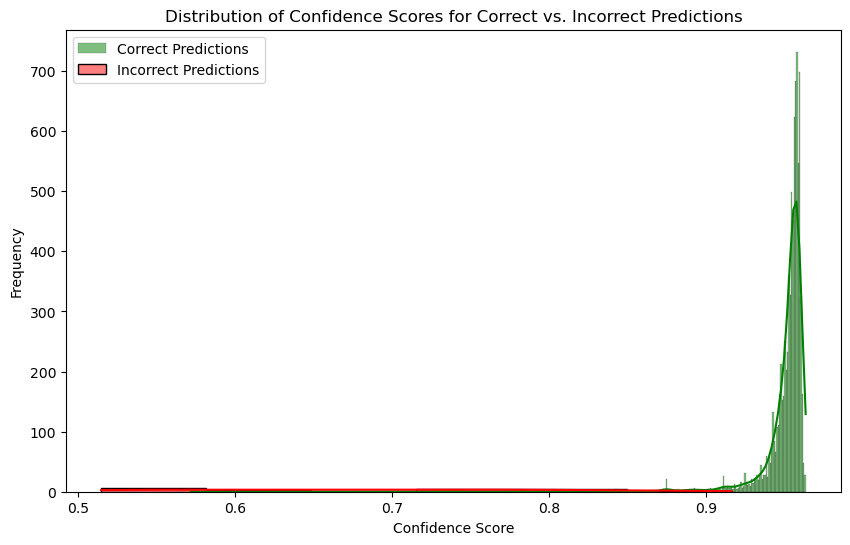

In [25]:
# Define correct and incorrect predictions
correct_predictions = df[(df['DataBERT_label'] == 1) & (df['label'] == 1)]
incorrect_predictions = df[(df['DataBERT_label'] == 1) & (df['label'] == 0)]

# Plot the distribution of confidence scores for correct and incorrect predictions
plt.figure(figsize=(10, 6))
sns.histplot(correct_predictions['confidence'], color='green', label='Correct Predictions', kde=True)
sns.histplot(incorrect_predictions['confidence'], color='red', label='Incorrect Predictions', kde=True)
plt.title('Distribution of Confidence Scores for Correct vs. Incorrect Predictions')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Analyze high confidence incorrect predictions and low confidence correct predictions
high_confidence_incorrect = incorrect_predictions[incorrect_predictions['confidence'] > 0.9]
low_confidence_correct = correct_predictions[correct_predictions['confidence'] < 0.6]

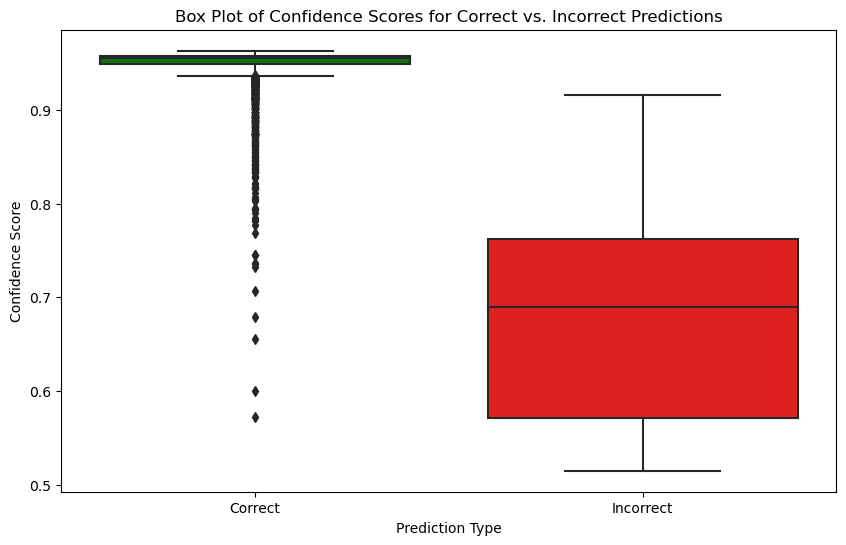

In [26]:
plt.figure(figsize=(10, 6))

# Combine correct and incorrect predictions into a single DataFrame for plotting
combined_data = pd.concat([
    correct_predictions.assign(Prediction='Correct'),
    incorrect_predictions.assign(Prediction='Incorrect')
])

# Create a box plot
sns.boxplot(x='Prediction', y='confidence', data=combined_data, palette=['green', 'red'])
plt.title('Box Plot of Confidence Scores for Correct vs. Incorrect Predictions')
plt.xlabel('Prediction Type')
plt.ylabel('Confidence Score')
plt.show()


# Evaluating Training Data: Second iteration

In [27]:
PATH = "/Users/jamesliounis/Documents/Projects/World Bank/NLP Project/data-use/data/annotated/training_data_annotated_v2.xlsx"

data = pd.read_excel(PATH)

data.head()

,text,label,data_origin,has_data_v1,confidence_v1,has_data_v2,confidence_v2,Delta_v1,Delta_v2
0,We analyze the relationship between climate ch...,1,GPT-generated data (old),1,0.9585,1,0.9263,0.0415,0.0737
1,Using a dataset from the World Trade Organizat...,1,GPT-generated data (old),1,0.9535,1,0.9075,0.0465,0.0925
2,This study examines the impact of school-based...,1,GPT-generated data (old),1,0.9466,1,0.8995,0.0534,0.1005
3,We explore the impact of electricity access on...,1,GPT-generated data (old),1,0.9585,1,0.9257,0.0415,0.0743
4,To investigate the relationship between social...,1,GPT-generated data (old),1,0.9395,1,0.8928,0.0605,0.1072


In [28]:
# def extract_v1_results(row):
#     # Evaluate the string as a literal tuple
#     result = eval(row['DatastilBERT_v1_classification'])
#     return pd.Series([result[0], result[1]])

# def extract_v2_results(row):
#     # Evaluate the string as a list containing a dictionary
#     result = eval(row['DatastilBERT_v2_classification'])[0]
#     return pd.Series([result['label'], result['score']])

# data[['has_data_v1', 'confidence_v1']] = data.apply(extract_v1_results, axis=1)
# data[['has_data_v2', 'confidence_v2']] = data.apply(extract_v2_results, axis=1)

# data.drop(['DatastilBERT_v1_classification', 'DatastilBERT_v2_classification', 'Unnamed: 0'], inplace=True, axis=1)

# data.head()


In [29]:
data['has_data_v1'] = data['has_data_v1'].apply(lambda x: 1 if x == 'WITH_DATA' else 0)
data['has_data_v2'] = data['has_data_v2'].apply(lambda x: 1 if x == 'WITH_DATA' else 0)

data['confidence_v1'] = data['confidence_v1'].apply(lambda x: round(x, 4))
data['confidence_v2'] = data['confidence_v2'].apply(lambda x: round(x, 4))

data['Delta_v1'] = np.abs(data["label"] - data['confidence_v1'])
data['Delta_v2'] = np.abs(data["label"] - data['confidence_v2'])

## Analyzing False Positives

In [30]:
data.query("label == 0 & has_data_v2 == 1")

,text,label,data_origin,has_data_v1,confidence_v1,has_data_v2,confidence_v2,Delta_v1,Delta_v2


The predictions result only in two false positives in this case:

```bash
'The Intergovernmental Panel on Climate Change (IPCC) has concluded that climate change is real and primarily caused by human activities.'
'The Paris Agreement is a legally binding agreement under the United Nations Framework Convention on Climate Change (UNFCCC).'
```
- Confidence_v2 = 0.6551 and 0.5197
- Confidence_v1 = 0.9161 and 0.8326

These False Positives were also identified in the first iteration of the model with the model struggling with entities, classifying them as text. However, it seems like the confidence in these classifications has decreased signifcantly (almost halved!), which is promising. 

A comment needs to be made regarding the source of data here: this comes from the HF dataset which states "claims". Thus, a new possible argument here may be regarding the form or the tenses used. This is particularly true in regard to the use of "authoritative statements". A model might confuse general authoritative statements or mentions of official reports with dataset mentions if it has not learned the nuanced differences adequately. For instance, terms like "Intergovernmental Panel on Climate Change (IPCC)" or "Paris Agreement" might be associated in the training data with contexts where datasets are typically discussed, leading to false positives.




# Analyzing False Negatives

In [31]:
data.query('label == 1 & has_data_v2 == 0')['text'].to_list()

["We analyze the relationship between climate change and crop yields in Africa, using data from the World Bank's Living Standards Measurement Study — Integrated Surveys on Agriculture (LSMS-ISA) and the Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS).",
 'Using a dataset from the World Trade Organization on bilateral trade flow and applied tariff data for 75 countries over 30 years, we investigate the impact of non-tariff measures (NTMs) on trade flows.',
 'This study examines the impact of school-based management interventions on primary school student learning outcomes, using data from the Philippine Informal Reading Inventory (Phil-IRI) and the National Achievement Test (NAT).',
 "We explore the impact of electricity access on household welfare using data from the Demographic and Health Survey (DHS) and the World Bank's Living Standards Measurement Study (LSMS), both conducted in Nigeria.",
 'To investigate the relationship between social protection programs 

Previously, we only had one False Negative. We now have 5. This may be because of the more stringest requirements we imposed on our training data, which had a particular emphasis on False Positives. This seems to come at a cost of a few additional false negatives. 

- Average confidence score for false negatives v2: $0.54$
- Average $\Delta$ for false negatives v2: $0.45$

Sentence #640 was incorrectly classified by V1 and is still incorrectly clasified. Confidence in Model V2 however seems to have increased by 4% (0.66).

```bash
'We use Webscope advertising logs, which consist of a large collection of user-page interactions from a major search and advertising company, to investigate privacy-protected algorithms for targeted advertising in online search.'
```

These sentences are the new wrongly classified sentences. They all explicitly mention the use of data, but it seems like the common characteristic across them are that they do not have a dataset **name** mentioned explicitly. Additional focus needs to be given on 2 elements in further iterations:

1. Subtleness in stating dataset mentions: model needs to be able to identify datasets without the explicit mention of a dataset name, and with a large variety of words that may also mean dataset. We need to increase the lexical field. 

2. Data sources: the model still struggles to identify data from different sources. A significant emphasis needs to be put on a wide range of sources. This is particularly true given the fact that we are primarily concerned with economic activity data, which may often come from very unusual sources. 







/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'accuracy': 0.5}


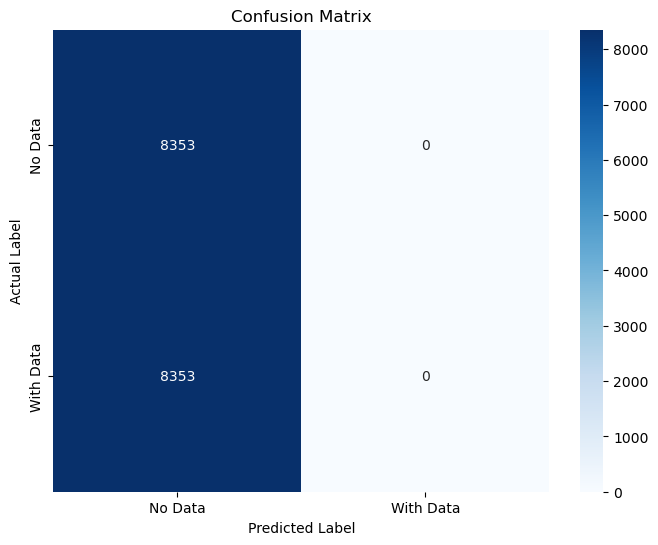

In [32]:
# Calculating performance metrics
y_true = data['label']
y_pred = data['has_data_v2']

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred)

metrics_dic= {
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "accuracy": accuracy
}

print(metrics_dic)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Data", "With Data"], yticklabels=["No Data", "With Data"])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

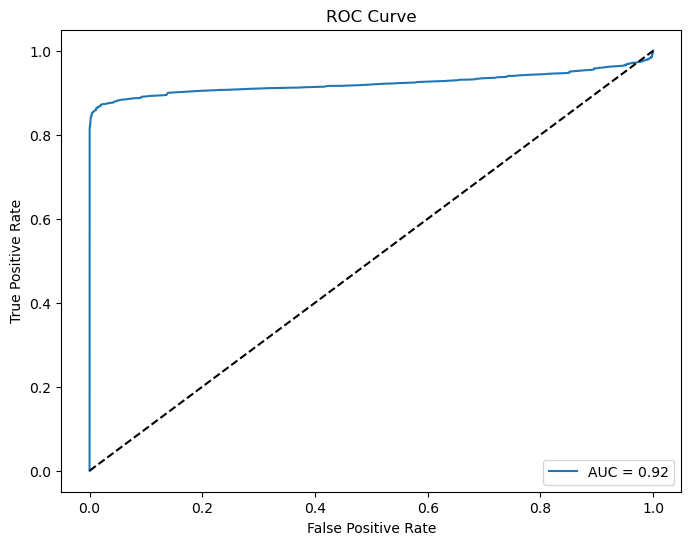

0.9221839475717469

In [33]:
# Assuming the 'confidence' values are the probability estimates for the positive class
y_score = data['confidence_v2']

# Calculating the ROC curve and AUC metric
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_score = roc_auc_score(y_true, y_score)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

auc_score


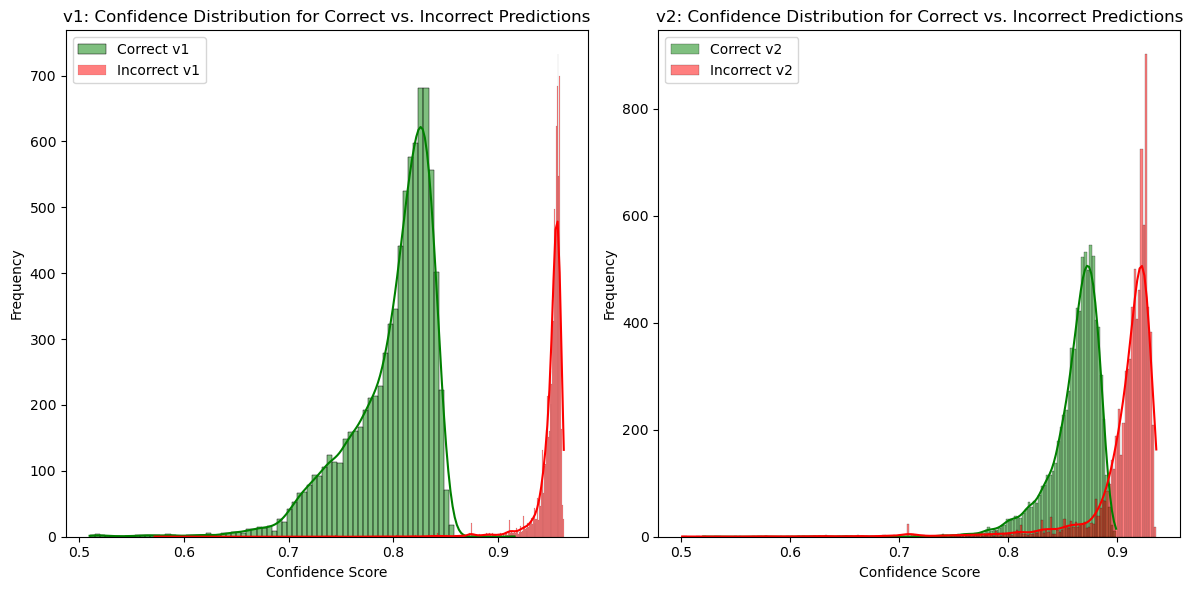

{'high_confidence_incorrect_v1': 8169,
 'low_confidence_correct_v1': 32,
 'high_confidence_incorrect_v2': 6630,
 'low_confidence_correct_v2': 2}

In [34]:
# Define correct and incorrect predictions for both versions
correct_predictions_v1 = data[(data['has_data_v1'] == data['label'])]
incorrect_predictions_v1 = data[(data['has_data_v1'] != data['label'])]

correct_predictions_v2 = data[(data['has_data_v2'] == data['label'])]
incorrect_predictions_v2 = data[(data['has_data_v2'] != data['label'])]

# Plot the distribution of confidence scores for correct and incorrect predictions for both model versions
plt.figure(figsize=(12, 6))

# Subplot for Model v1
plt.subplot(1, 2, 1)
sns.histplot(correct_predictions_v1['confidence_v1'], color='green', label='Correct v1', kde=True)
sns.histplot(incorrect_predictions_v1['confidence_v1'], color='red', label='Incorrect v1', kde=True)
plt.title('v1: Confidence Distribution for Correct vs. Incorrect Predictions')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()

# Subplot for Model v2
plt.subplot(1, 2, 2)
sns.histplot(correct_predictions_v2['confidence_v2'], color='green', label='Correct v2', kde=True)
sns.histplot(incorrect_predictions_v2['confidence_v2'], color='red', label='Incorrect v2', kde=True)
plt.title('v2: Confidence Distribution for Correct vs. Incorrect Predictions')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Analyze high confidence incorrect predictions and low confidence correct predictions for both versions
high_confidence_incorrect_v1 = incorrect_predictions_v1[incorrect_predictions_v1['confidence_v1'] > 0.9]
low_confidence_correct_v1 = correct_predictions_v1[correct_predictions_v1['confidence_v1'] < 0.6]

high_confidence_incorrect_v2 = incorrect_predictions_v2[incorrect_predictions_v2['confidence_v2'] > 0.9]
low_confidence_correct_v2 = correct_predictions_v2[correct_predictions_v2['confidence_v2'] < 0.6]

# Summary of high confidence incorrect and low confidence correct predictions for both versions
summary = {
    'high_confidence_incorrect_v1': len(high_confidence_incorrect_v1),
    'low_confidence_correct_v1': len(low_confidence_correct_v1),
    'high_confidence_incorrect_v2': len(high_confidence_incorrect_v2),
    'low_confidence_correct_v2': len(low_confidence_correct_v2)
}

summary


The plots above show the confidence distributions for correct (green) and incorrect (red) predictions for both versions of your model.

Here's what we can observe:

- Model v1: In the first version of the model, there is one instance of a high-confidence incorrect prediction (confidence > 0.9). Additionally, there are 26 instances where the model was correct but with low confidence (confidence < 0.6).
- Model v2: In the second version, there are no instances of high-confidence incorrect predictions, which is an improvement. There are fewer instances (16) of correct but low-confidence predictions, which also suggests an improvement in model calibration.

# Analyzing using Ranking Scores

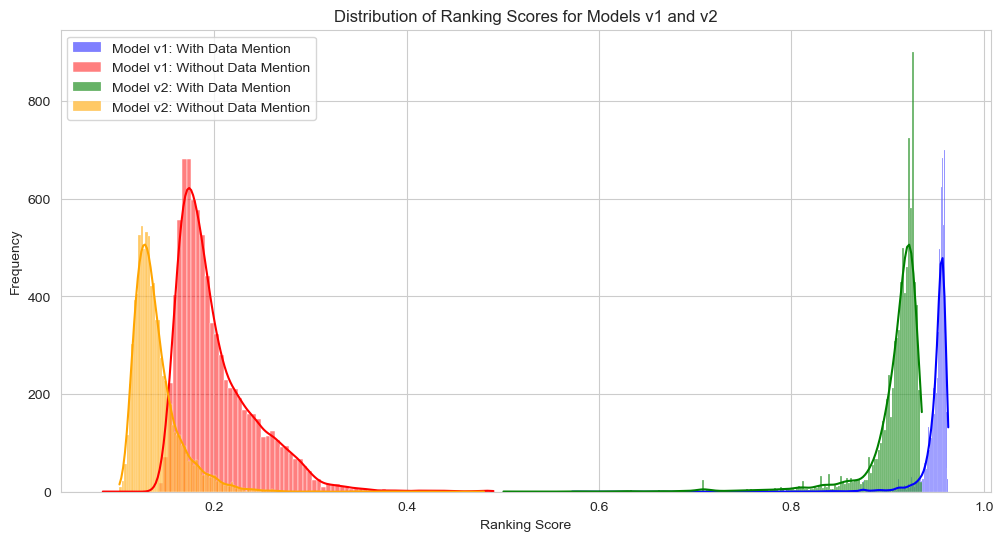

In [39]:
# Setting up the plot
plt.figure(figsize=(12, 6))

# Plotting distributions for model v1
data_with_data_v1 = data[data['label'] == 1]['confidence_v1']
data_without_data_v1 = 1 - data[data['label'] == 0]['confidence_v1']
sns.histplot(data_with_data_v1, color='blue', label='Model v1: With Data Mention', kde=True)
sns.histplot(data_without_data_v1, color='red', label='Model v1: Without Data Mention', kde=True)

# Plotting distributions for model v2
data_with_data_v2 = data[data['label'] == 1]['confidence_v2']
data_without_data_v2 = 1 - data[data['label'] == 0]['confidence_v2']
sns.histplot(data_with_data_v2, color='green', label='Model v2: With Data Mention', kde=True, alpha=0.6)
sns.histplot(data_without_data_v2, color='orange', label='Model v2: Without Data Mention', kde=True, alpha=0.6)

plt.title('Distribution of Ranking Scores for Models v1 and v2')
plt.xlabel('Ranking Score')
plt.ylabel('Frequency')
plt.legend()

plt.show()


# Comparing the two models

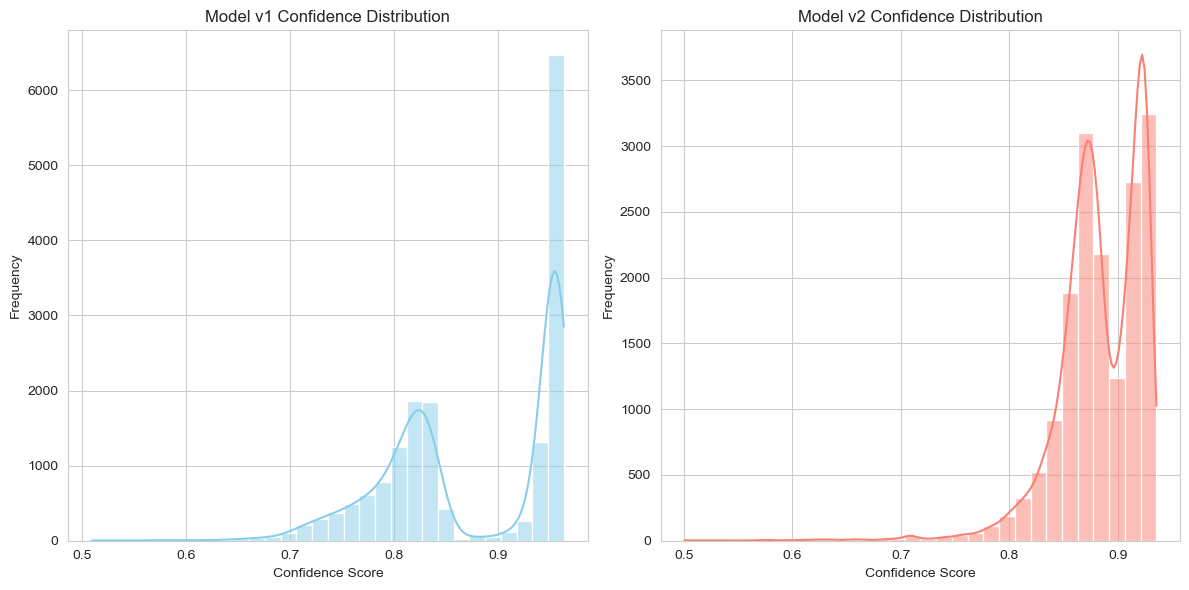

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plots
sns.set_style("whitegrid")

# Create a figure with two subplots for side-by-side comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the confidence distribution for v1
sns.histplot(data['confidence_v1'], bins=30, kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Model v1 Confidence Distribution')
ax[0].set_xlabel('Confidence Score')
ax[0].set_ylabel('Frequency')

# Plot the confidence distribution for v2
sns.histplot(data['confidence_v2'], bins=30, kde=True, ax=ax[1], color='salmon')
ax[1].set_title('Model v2 Confidence Distribution')
ax[1].set_xlabel('Confidence Score')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


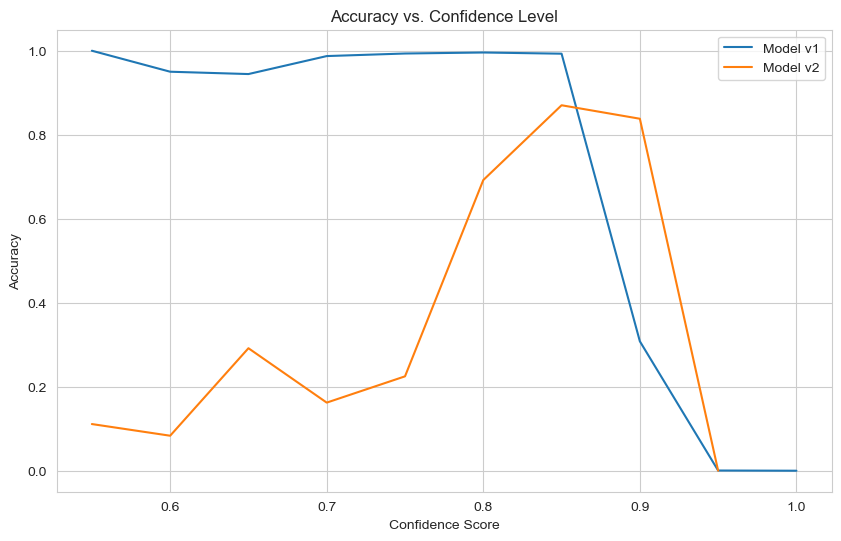

In [36]:
# Define a function to calculate accuracy for different confidence bins
def accuracy_per_confidence_bin(df, label_col, pred_col, conf_col, bins):
    # Bin the confidence scores
    df['confidence_bin'] = pd.cut(df[conf_col], bins=bins, labels=np.round(np.linspace(bins[0], bins[-1], num=len(bins))[1:], 2))
    # Calculate accuracy for each bin
    accuracy_per_bin = df.groupby('confidence_bin').apply(lambda x: (x[label_col] == x[pred_col]).mean())
    return accuracy_per_bin

# Define confidence bins
confidence_bins = np.linspace(0, 1, 21)

# Calculate accuracy for each confidence bin for both model versions
accuracy_per_bin_v1 = accuracy_per_confidence_bin(data, 'label', 'has_data_v1', 'confidence_v1', confidence_bins)
accuracy_per_bin_v2 = accuracy_per_confidence_bin(data, 'label', 'has_data_v2', 'confidence_v2', confidence_bins)

# Plot accuracy as a function of confidence for both models
plt.figure(figsize=(10, 6))
sns.lineplot(x=accuracy_per_bin_v1.index.astype(float), y=accuracy_per_bin_v1, label='Model v1')
sns.lineplot(x=accuracy_per_bin_v2.index.astype(float), y=accuracy_per_bin_v2, label='Model v2')

plt.title('Accuracy vs. Confidence Level')
plt.xlabel('Confidence Score')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


The plot above illustrates how the accuracy of each model version changes with different confidence levels:

- For both models, accuracy tends to increase with confidence, which is expected in well-calibrated models.
- There are some confidence intervals where the accuracy for v2 is slightly lower than for v1, especially in the mid-confidence range (around 0.6 to 0.8). This could suggest that v2 is somewhat less accurate in this range, potentially indicating that the additional data introduced cases that were more challenging for the model.
- At the highest confidence levels (above 0.9), both models seem to perform similarly, maintaining high accuracy.

However, there are fluctuations, particularly in the mid-range, which suggests that the relationship between confidence and accuracy may not be perfectly linear and could benefit from further calibration. It's also worth noting that where there are steep changes or significant fluctuations in accuracy, it could be due to a small number of samples in those confidence bins, which can cause variability.

Mean change in delta: 0.05323113252723493
Median change in delta: 0.044399999999999995


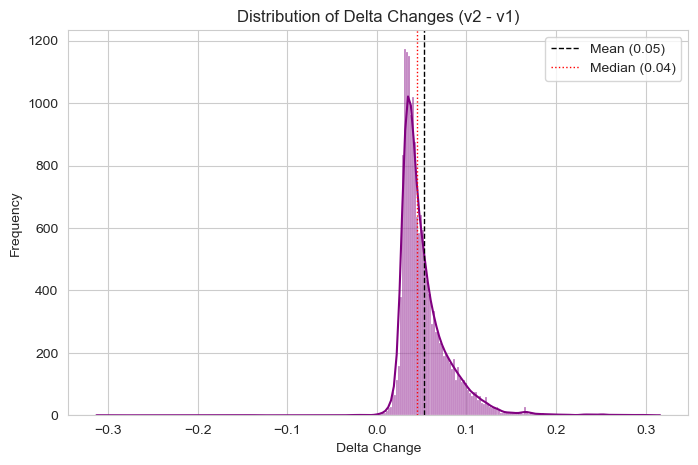

In [37]:
# Calculate the change in delta for each data point
data['delta_change'] = data['Delta_v2'] - data['Delta_v1']

# Calculate summary statistics for the delta change
delta_change_mean = data['delta_change'].mean()
delta_change_median = data['delta_change'].median()

# Print out the mean and median delta change
print(f"Mean change in delta: {delta_change_mean}")
print(f"Median change in delta: {delta_change_median}")

# Plot the distribution of delta changes
plt.figure(figsize=(8, 5))
sns.histplot(data['delta_change'], kde=True, color='purple')
plt.title('Distribution of Delta Changes (v2 - v1)')
plt.xlabel('Delta Change')
plt.ylabel('Frequency')
plt.axvline(delta_change_mean, color='k', linestyle='dashed', linewidth=1, label=f'Mean ({delta_change_mean:.2f})')
plt.axvline(delta_change_median, color='r', linestyle='dotted', linewidth=1, label=f'Median ({delta_change_median:.2f})')
plt.legend()
plt.show()


It seems like the Deltas have in general increased. However, we need to evaluate this in conjunction with the new metrics that we obtained, in particular accuracy. V2 has higher accuracy but also a higher $\Delta$ on average, which most likely means that it's just a more "cautious" model. 

Mean delta improvement (decrease): -0.09784074074074074
Median delta improvement (decrease): -0.04159999999999997
Mean delta worsening (increase): 0.05347568799088593
Median delta worsening (increase): 0.044399999999999995


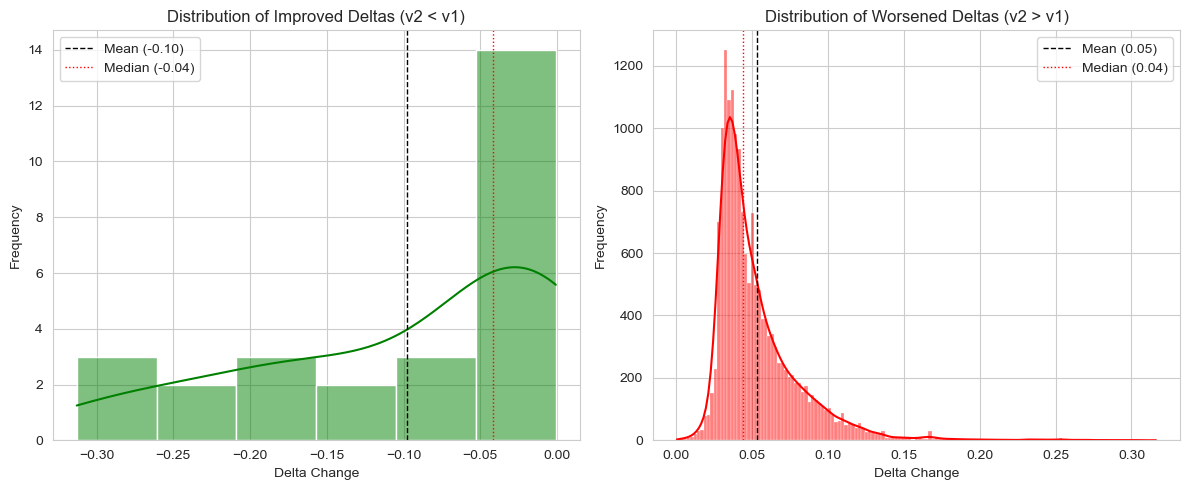

In [38]:
# Identify instances with improved and worsened deltas
improved_deltas = data[data['delta_change'] < 0]
worsened_deltas = data[data['delta_change'] > 0]

# Calculate summary statistics for improved and worsened deltas
improved_deltas_mean = improved_deltas['delta_change'].mean()
improved_deltas_median = improved_deltas['delta_change'].median()
worsened_deltas_mean = worsened_deltas['delta_change'].mean()
worsened_deltas_median = worsened_deltas['delta_change'].median()

# Output the summary statistics
print(f"Mean delta improvement (decrease): {improved_deltas_mean}")
print(f"Median delta improvement (decrease): {improved_deltas_median}")
print(f"Mean delta worsening (increase): {worsened_deltas_mean}")
print(f"Median delta worsening (increase): {worsened_deltas_median}")

# Plot the distribution of improved and worsened deltas
plt.figure(figsize=(12, 5))

# Plot for improved deltas
plt.subplot(1, 2, 1)
sns.histplot(improved_deltas['delta_change'], kde=True, color='green')
plt.title('Distribution of Improved Deltas (v2 < v1)')
plt.xlabel('Delta Change')
plt.ylabel('Frequency')
plt.axvline(improved_deltas_mean, color='k', linestyle='dashed', linewidth=1, label=f'Mean ({improved_deltas_mean:.2f})')
plt.axvline(improved_deltas_median, color='r', linestyle='dotted', linewidth=1, label=f'Median ({improved_deltas_median:.2f})')
plt.legend()

# Plot for worsened deltas
plt.subplot(1, 2, 2)
sns.histplot(worsened_deltas['delta_change'], kde=True, color='red')
plt.title('Distribution of Worsened Deltas (v2 > v1)')
plt.xlabel('Delta Change')
plt.ylabel('Frequency')
plt.axvline(worsened_deltas_mean, color='k', linestyle='dashed', linewidth=1, label=f'Mean ({worsened_deltas_mean:.2f})')
plt.axvline(worsened_deltas_median, color='r', linestyle='dotted', linewidth=1, label=f'Median ({worsened_deltas_median:.2f})')
plt.legend()

plt.tight_layout()
plt.show()
